

```
Background:
Illumination and Reflectance Model in Image Formation

Images are denoted by two dimensional function of the form f(x,y) whose value is a scalar quantity and it depends on the amplitude of f at the spatial coordinates (x,y)  [1]

f(x,y) has two components:
Illumination
The amount of source illumination incident on the scene. This is the property of light source
Reflectance
The amount of illumination reflected by the objects in the scene. This is the property of the object

    f(x,y) = i(x,y) r(x,y)

Illumination has low frequency and reflectance has high frequency properties.

Homomorphic Filtering:
Most of the noise models have an additive property. The illumination and reflectance is a multiplicative model. Homomorphic filtering is used to remove multiplicative noise arising from the uneven illumination.

f(x,y) = i(x,y) r(x,y)

Convert it to logarithmic domain, to change f(x,y) to additive model

z(x,y) = ln ( i(x,y) r(x,y))  =  ln (i(x,y)) + ln (r(x,y))

Take Fourier transform of the above equations, from linearity property
ℱ{z(x,y)} = ℱ {ln (i(x,y))}  + ℱ{ln (r(x,y))} = Fi(u,v) + Fr(u,v)
Z(u,v) =  Fi(u,v) + Fr(u,v)

Using high pass filter H(u,v)  to remove the low frequency components of Illumination

S(u,v) = H(u,v) Z(u,v) = H(u,v) Fi(u,v) + H(u,v) Fr(u,v)

The image in spatial domain is 
s(x,y) = ℱ-1{S(u,v)} =  ℱ-1{H(u,v) Fi(u,v) }  + ℱ-1{H(u,v) Fr(u,v)} 
s(x,y) = i`(x,y) + r`(x,y)
Take the exponential to reverse logarithm domain taken in step 1
g(x,y) = e s(x,y)  =    e  i`(x,y) + r`(x,y) = i’’(x,y) r’’(x,y)

```



How will this help?
By using an appropriate high pass filter will filter out the low frequency noise caused by uneven illumination.


In [16]:
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
import scipy
import matplotlib.pyplot as plt
import numpy as np

Gaussian High Pass Filter:
1. Create a matrix and initialize it with 0
2. Find duv = (X-mean1)^2 + (Y-mean2)^2
3. Low pass filter value is e^(-duv/2*standard_dev^2)
4. High pass filter = 1 - low pass 

In [17]:
def GaussianHighPass(shape,sigma=5):
    #find the middle points
    P = shape[0]/2
    Q = shape[1]/2

    #initialize the matrix with 0s
    H = np.zeros(shape)
    X, Y = np.meshgrid(range(shape[0]), range(shape[1]), indexing='ij')
    
    #distance from the center
    duv = (((X-P)**2+(Y-Q)**2)).astype(float)
    #low pass
    H = np.exp(-duv/ (2*sigma**2))

    #high pass
    return (1 - H)


I have placed my image in github repository

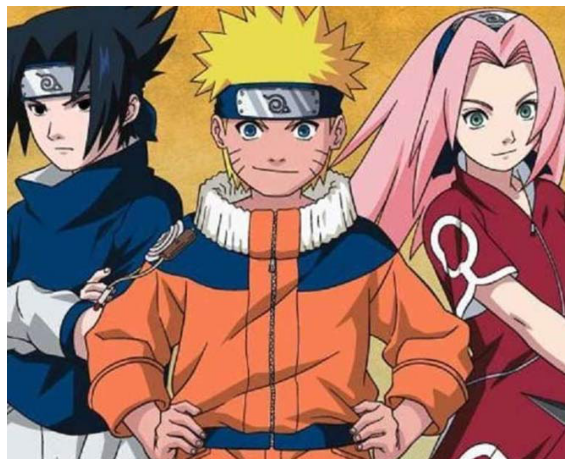

In [18]:
image_path = "https://raw.githubusercontent.com/Srigowri/Classical-Image-Processing/main/assests/naruto.jpg"

image = io.imread(image_path)

#show thei image
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(image)

Writing the image temporarily to drive

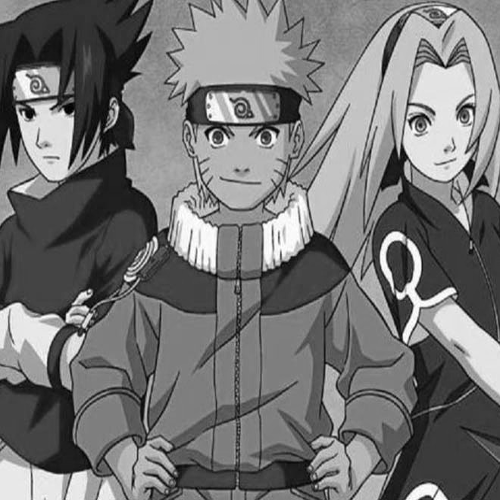

In [19]:
cv2.imwrite("./ocean.jpeg",image)
img = cv2.imread("/content/ocean.jpeg",cv2.IMREAD_GRAYSCALE)
img  =cv2.resize(img,(500,500),interpolation=cv2.INTER_CUBIC)
cv2_imshow(img)

# **Log transformation**

In [20]:

# Normalize the image to have intensity values between 0 and 1
imgnormalized = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

#take the log to change the multiplication to addition of illumination and relectance
logTransform = np.log1p(imgnormalized)

# **Fourier Transform**

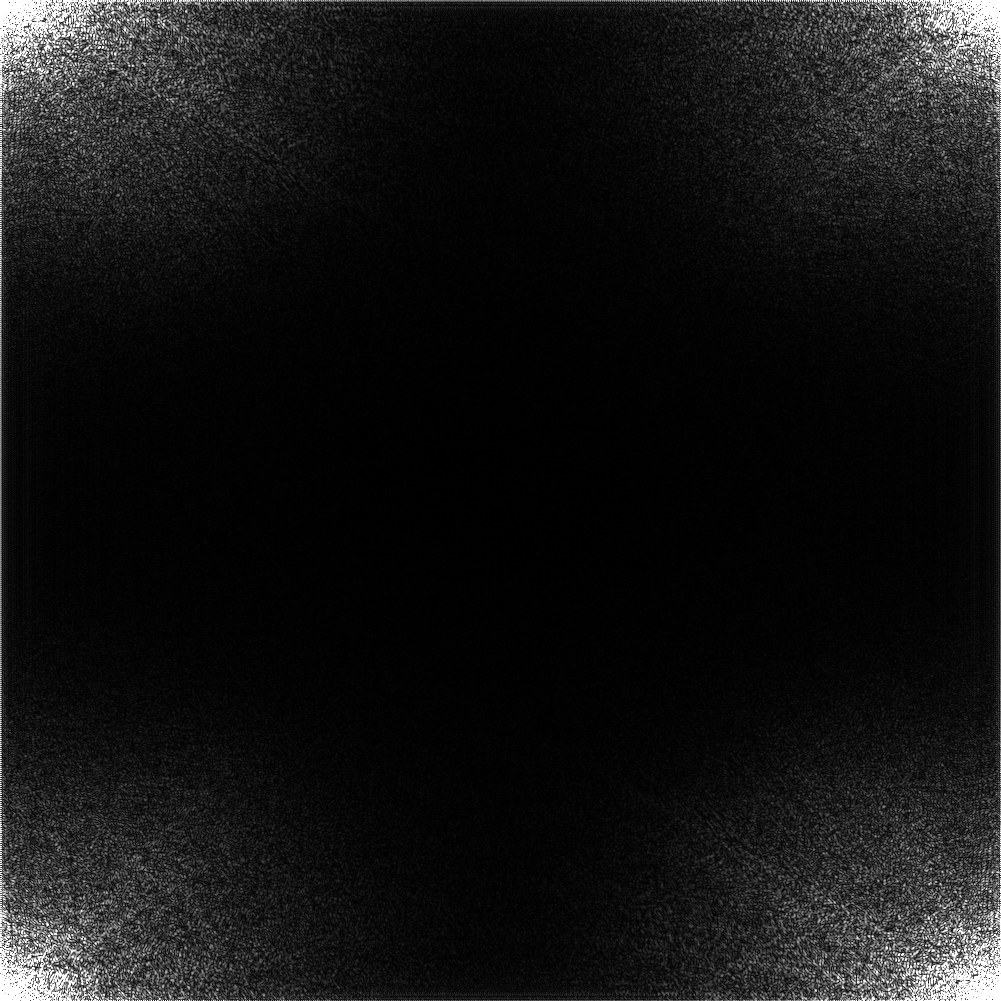

In [21]:
#zero padding fft
M = 2*img.shape[0] + 1
N = 2*img.shape[1] + 1

#Take the fourier transform in complex axis only
fourierTransform = np.fft.fft2(logTransform,[M,N],axes=(0,1))
cv2_imshow(np.abs(fourierTransform))

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


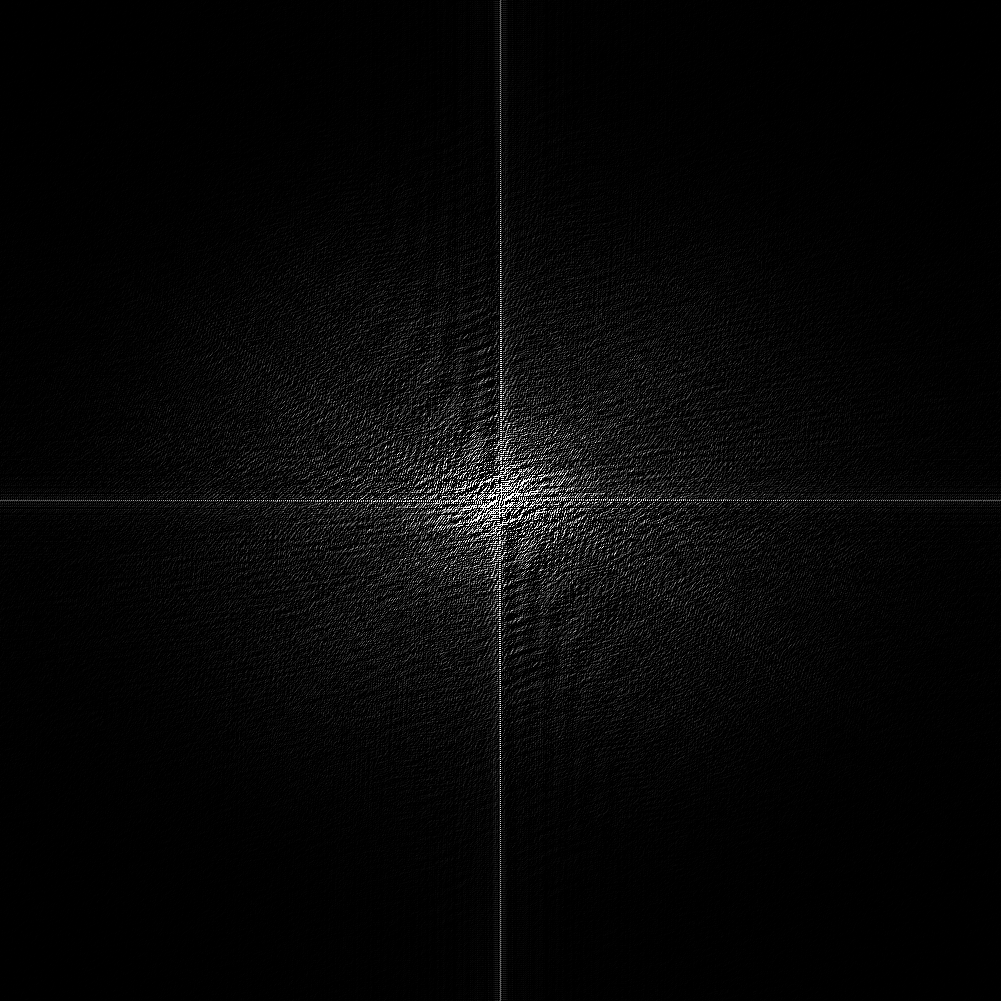

In [22]:
#centered fft

cv2_imshow(np.fft.fftshift(fourierTransform))


# **High Pass Filter**

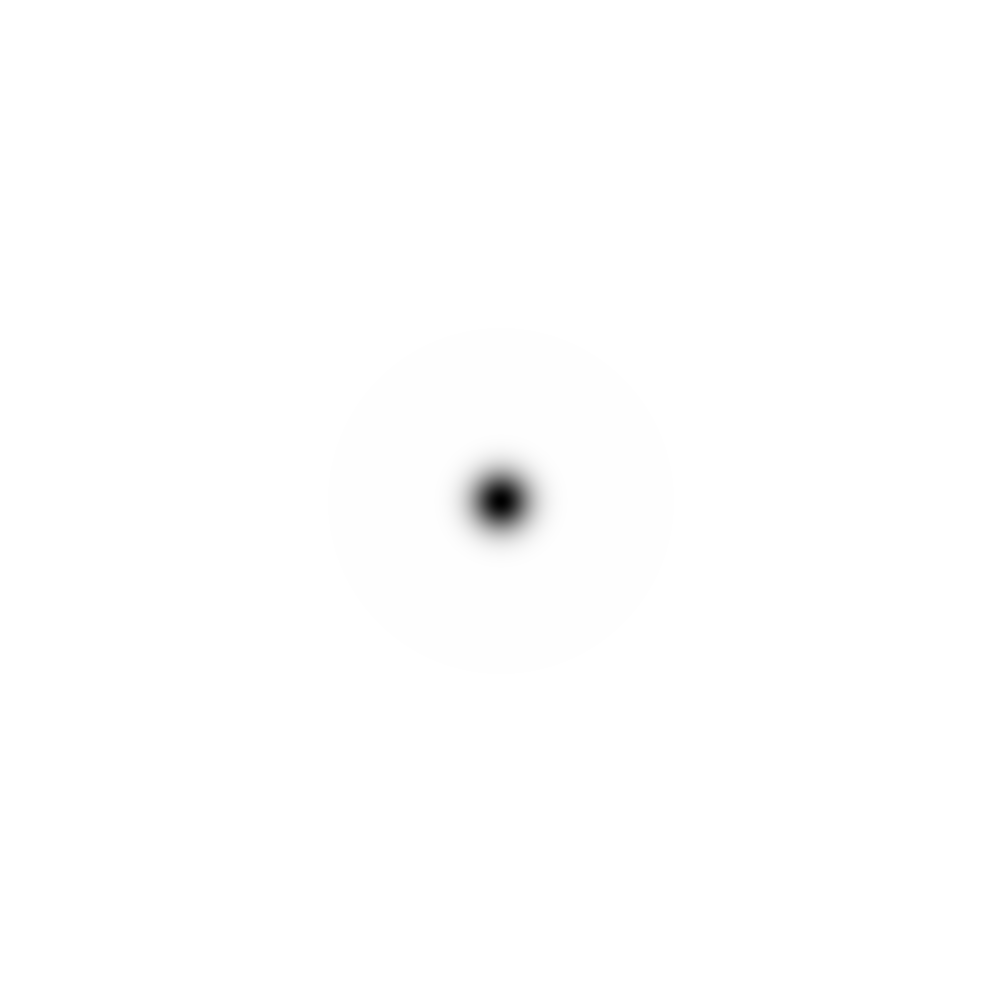

In [23]:
#get the high pass filter
highpassFilter = GaussianHighPass(fourierTransform.shape,sigma=20)
#normalize the high pass filter value to lie in the range[0-1]
HFNormalized = cv2.normalize(highpassFilter.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

#below line are only for plotting purposes, I am denormalizing the pixels to range[0-255] and plotting it
cv2_imshow(cv2.normalize(HFNormalized.astype('float'), None, 0.0, 255.0, cv2.NORM_MINMAX))

# **Center the filter**

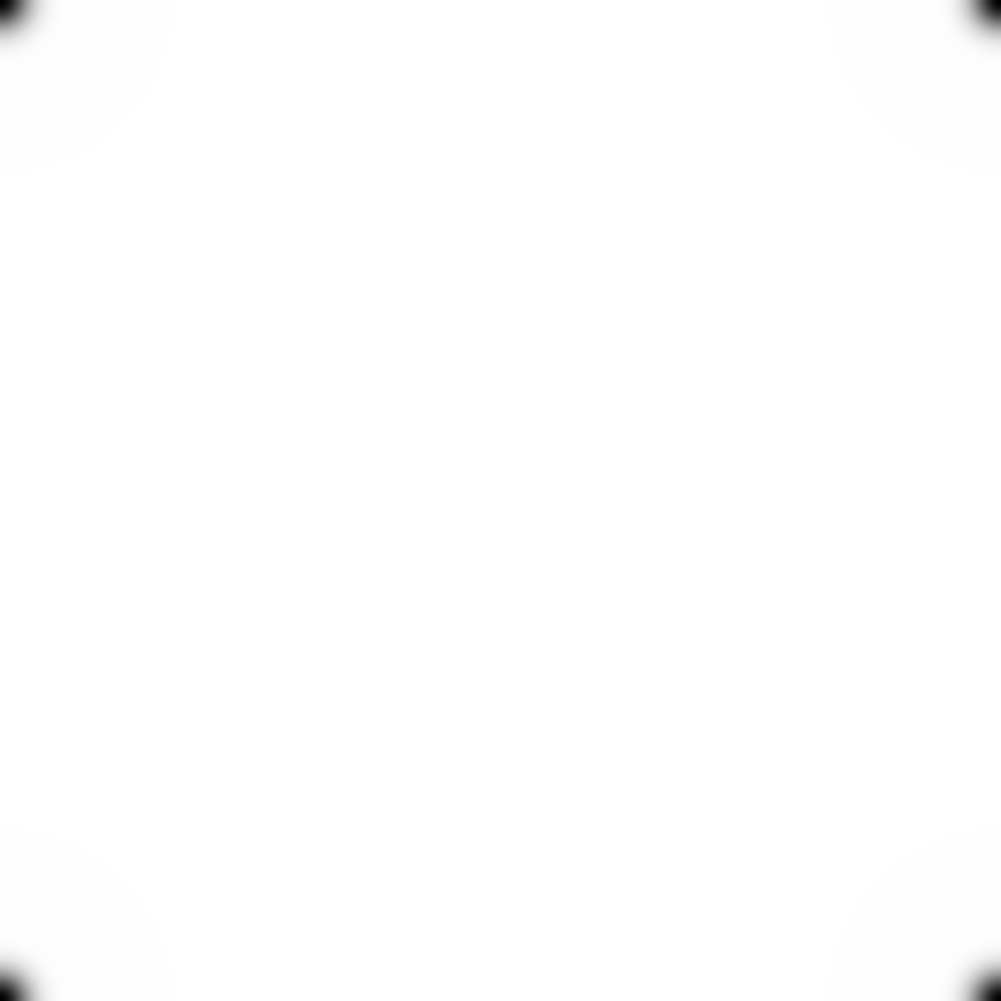

In [24]:
#center the filter
H = np.fft.fftshift(HFNormalized)


#below line are only for plotting purposes, I am denormalizing the pixels to range[0-255] and plotting it
cv2_imshow(cv2.normalize(H.astype('float'), None, 0.0, 255.0, cv2.NORM_MINMAX))

# **Inverse Fourier Transform**

In [25]:
#Take element wise product of the filter in frequency domain and the fourier transform of the input image
inverseFourierTransform = np.real(np.fft.ifft2(H*fourierTransform))

In [26]:
#resizing the transformed image into original image as I had previously zero padded
print(inverseFourierTransform.shape)
inverseFourierTransform = inverseFourierTransform[:img.shape[0],:img.shape[1]]
print(inverseFourierTransform.shape)

(1001, 1001)
(500, 500)


# **Inverse Log Transform or Exponential**

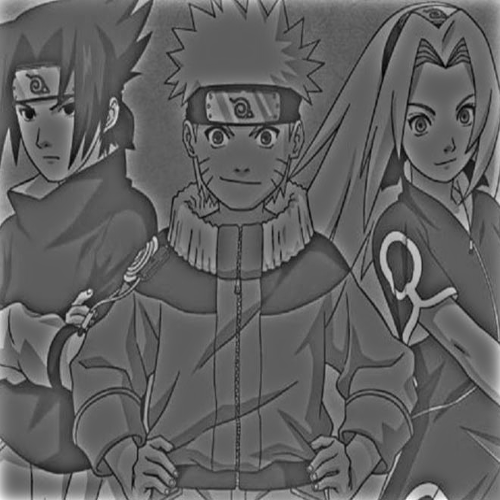

In [27]:
output = np.exp(inverseFourierTransform)
cv2_imshow(cv2.normalize(output.astype('float'), None, 0.0, 255.0, cv2.NORM_MINMAX))

In [28]:

def homomorphicFiltering(fourierTransform,sigma):
    #get the high pass filter
    highpassFilter = GaussianHighPass(fourierTransform.shape,sigma)
    #normalize the high pass filter value to lie in the range[0-1]
    HFNormalized = cv2.normalize(highpassFilter.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    #center the filter
    H = np.fft.fftshift(HFNormalized)
    #Take element wise product of the filter in frequency domain and the fourier transform of the input image
    inverseFourierTransform = np.real(np.fft.ifft2(H*fourierTransform))

    #resizing to original image size
    inverseFourierTransform = inverseFourierTransform[:img.shape[0],:img.shape[1]]
    #inverse log transform
    output = np.exp(inverseFourierTransform)
    return highpassFilter,output


filters = []
outputs = []
for sigma in [5,10,20,25,30,50,100]:
    filter,output = homomorphicFiltering(fourierTransform,sigma)
    
    filters.append(cv2.normalize(filter.astype('float'), None, 0.0, 255.0, cv2.NORM_MINMAX))
    outputs.append(cv2.normalize(output.astype('float'), None, 0.0, 255.0, cv2.NORM_MINMAX))




In [29]:
filtergrid = cv2.hconcat([out for out in filters])
outputgrid = cv2.hconcat([out for out in outputs])

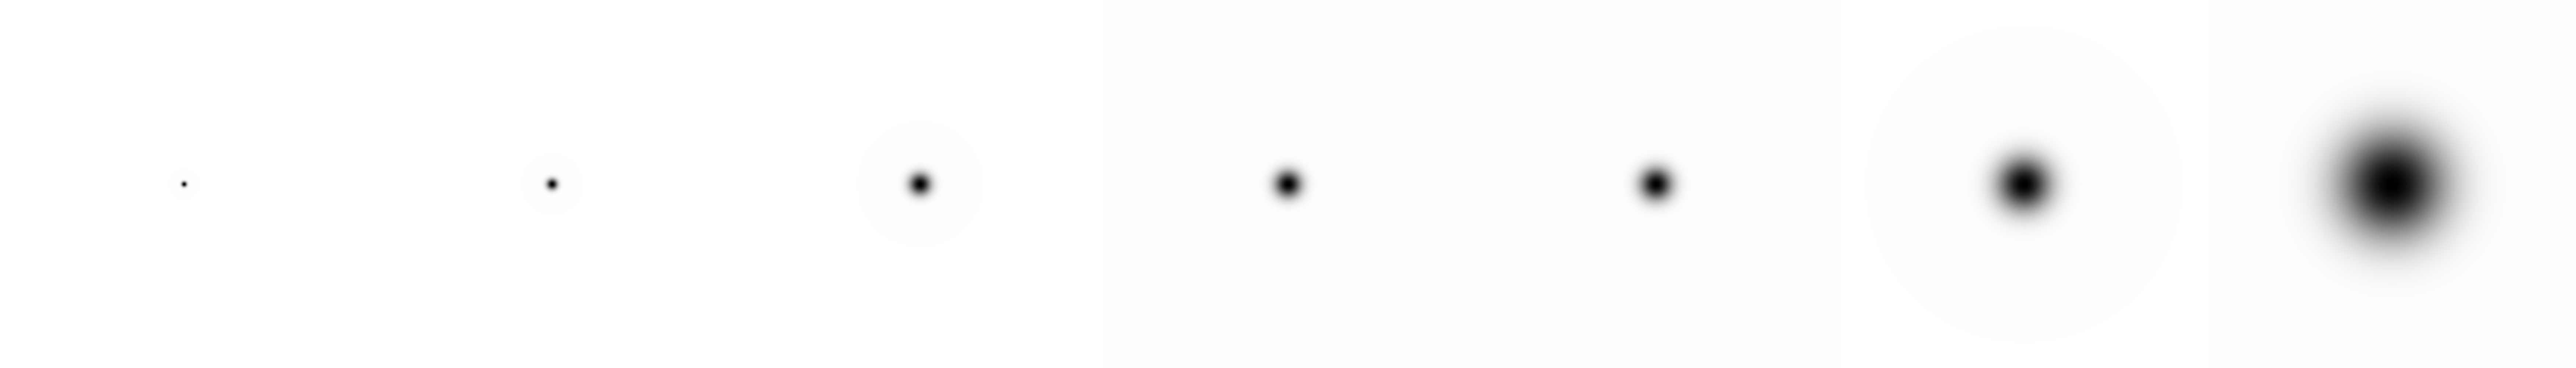

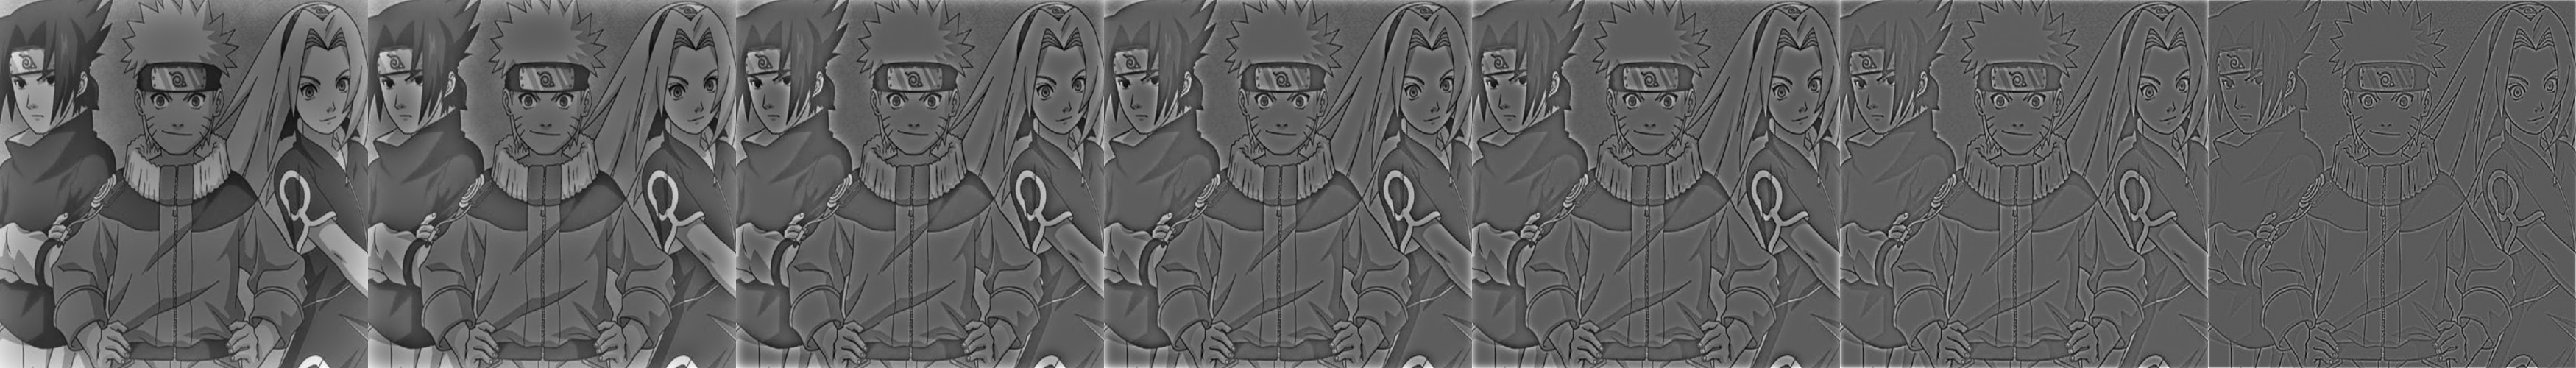

In [30]:
cv2_imshow(filtergrid)
cv2_imshow(outputgrid)